# UCI HAR - classification
- https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones

#### 데이터 종류
- 561개 특성으로 전처리된 메인 데이터셋(X_train, X_test)
- Inertial Signals 데이터셋: 원시 센서 값(raw signal)

#### Inertial Signals 데이터 구조
- 각 파일은 행 = 샘플(segment), 열 = 시계열 프레임을 의미
- 각 샘플은 2.56초 길이 (샘플링 주파수 50Hz, 128 타임스텝 → 128 / 50 = 2.56초)
- 이미 샘플링이 되어 있으므로(7352개의 샘플) split_sequence() 사용하지 않아도 됨
- 한 행이 (128,) 길이의 시계열 벡터
- 세 축(X, Y, Z)와 센서 종류(acc, gyro)로 분리되어 있음

#### 센서 및 값의 의미
- Total acceleration (total_acc): 스마트폰 가속도계로 측정한 총 가속도 (중력 + 신체 움직임 포함)
- Body acceleration (body_acc): 총 가속도에서 중력 성분을 제거한 값 (실제 동작 가속도)
- Gyroscope (body_gyro): 각속도(회전 속도), 단위는 rad/sec, 스마트폰의 자이로스코프 센서 값

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, Conv1D, BatchNormalization, ReLU, MaxPool1D, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]

In [4]:
TRAIN = "train/"
TEST = "test/"

DATASET_PATH = "/content/drive/MyDrive/AI_data/UCI_HAR_Dataset/UCI HAR Dataset/"

# Load "X"
def load_X(X_signals_paths):
    X_signals = []

    for signal_type_path in X_signals_paths:
        series_list = []  # 한 센서축 데이터 전체 저장

        with open(signal_type_path, 'r') as file:
            for row in file:
                row_clean = row.replace('  ', ' ') # 공백 2개를 1개로
                row_clean = row_clean.strip() # 양쪽 공백 제거
                serie = row_clean.split(' ') # 공백 기준 split
                serie_array = np.array(serie, dtype=np.float32) # float32 numpy 배열로 변환
                series_list.append(serie_array) # 시퀀스 추가

        # 하나의 센서축 데이터 추가 (feature)
        X_signals.append(series_list)

    # shape: (특성 수, 샘플 수, 타임스텝 수)
    X_signals = np.array(X_signals)
    # shape 변환 → (샘플 수, 타임스텝 수, 특성 수)
    return np.transpose(X_signals, (1, 2, 0))


X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt"
    for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt"
    for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (7352, 128, 9)
X_test shape: (2947, 128, 9)


In [5]:
# Load "y"

def load_y(y_path):
    with open(y_path, 'r') as file:
        labels = [int(line.strip()) for line in file]
    # 라벨을 0부터 시작하도록 -1 (원래 라벨이 1부터 시)
    return np.array(labels, dtype=np.int32) - 1


y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (7352,)
y_test shape: (2947,)


In [6]:
def positional_encoding(length, depth):
    depth = depth/2
    positions = np.arange(length)[:, np.newaxis] # 각 시퀀스 위치 pos 벡터
    depths = np.arange(depth)[np.newaxis, :]/depth # /depth로 정규화,
    angle_rates = 1 / (10000**depths)
    angle_rads = positions * angle_rates # broadcasting
    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)], axis=-1)
    return tf.cast(pos_encoding, dtype=tf.float32)

In [7]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = int(embed_dim)
        self.num_heads = int(num_heads)
        self.ff_dim = int(ff_dim)
        self.rate = float(rate)

        self.att = MultiHeadAttention(
            num_heads=self.num_heads,
            key_dim=self.embed_dim // self.num_heads
        )
        self.ffn = Sequential([
            Dense(self.ff_dim, activation="relu"),
            Dense(self.embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(self.rate)
        self.dropout2 = Dropout(self.rate)

    def call(self, inputs, training=None):
        attn = self.att(inputs, inputs, training=training)
        x1 = self.layernorm1(inputs + self.dropout1(attn, training=training))
        ffn = self.ffn(x1, training=training)
        return self.layernorm2(x1 + self.dropout2(ffn, training=training))

## Model 1
- CNN 2, GRU 1, Transformer 1
- Conv1D 출력과 TransformerBlock의 embed_dim 수가 일치해야함
- residual addition 할 때 shape이 맞아야 하기 때문

In [8]:
input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, features)
num_classes = 6

def build_model(input_shape, num_classes=6):
    inputs = Input(shape=input_shape)

    x = Conv1D(128, 5, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPool1D(2)(x)

    x = Conv1D(256, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = GRU(256, return_sequences=True)(x)

    pos_enc = positional_encoding(x.shape[1], x.shape[2])
    x += pos_enc

    x = TransformerBlock(embed_dim=256, num_heads=8, ff_dim=128)(x)

    x = GlobalAveragePooling1D()(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    return model

model = build_model(input_shape, num_classes)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 128, 128)       │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 64, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 64, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64, 256)        │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add (Add)                       │ (None, 64, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 64, 256)        │       330,112 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 864,518 (3.30 MB)

 Trainable params: 863,750 (3.29 MB)

 Non-trainable params: 768 (3.00 KB)

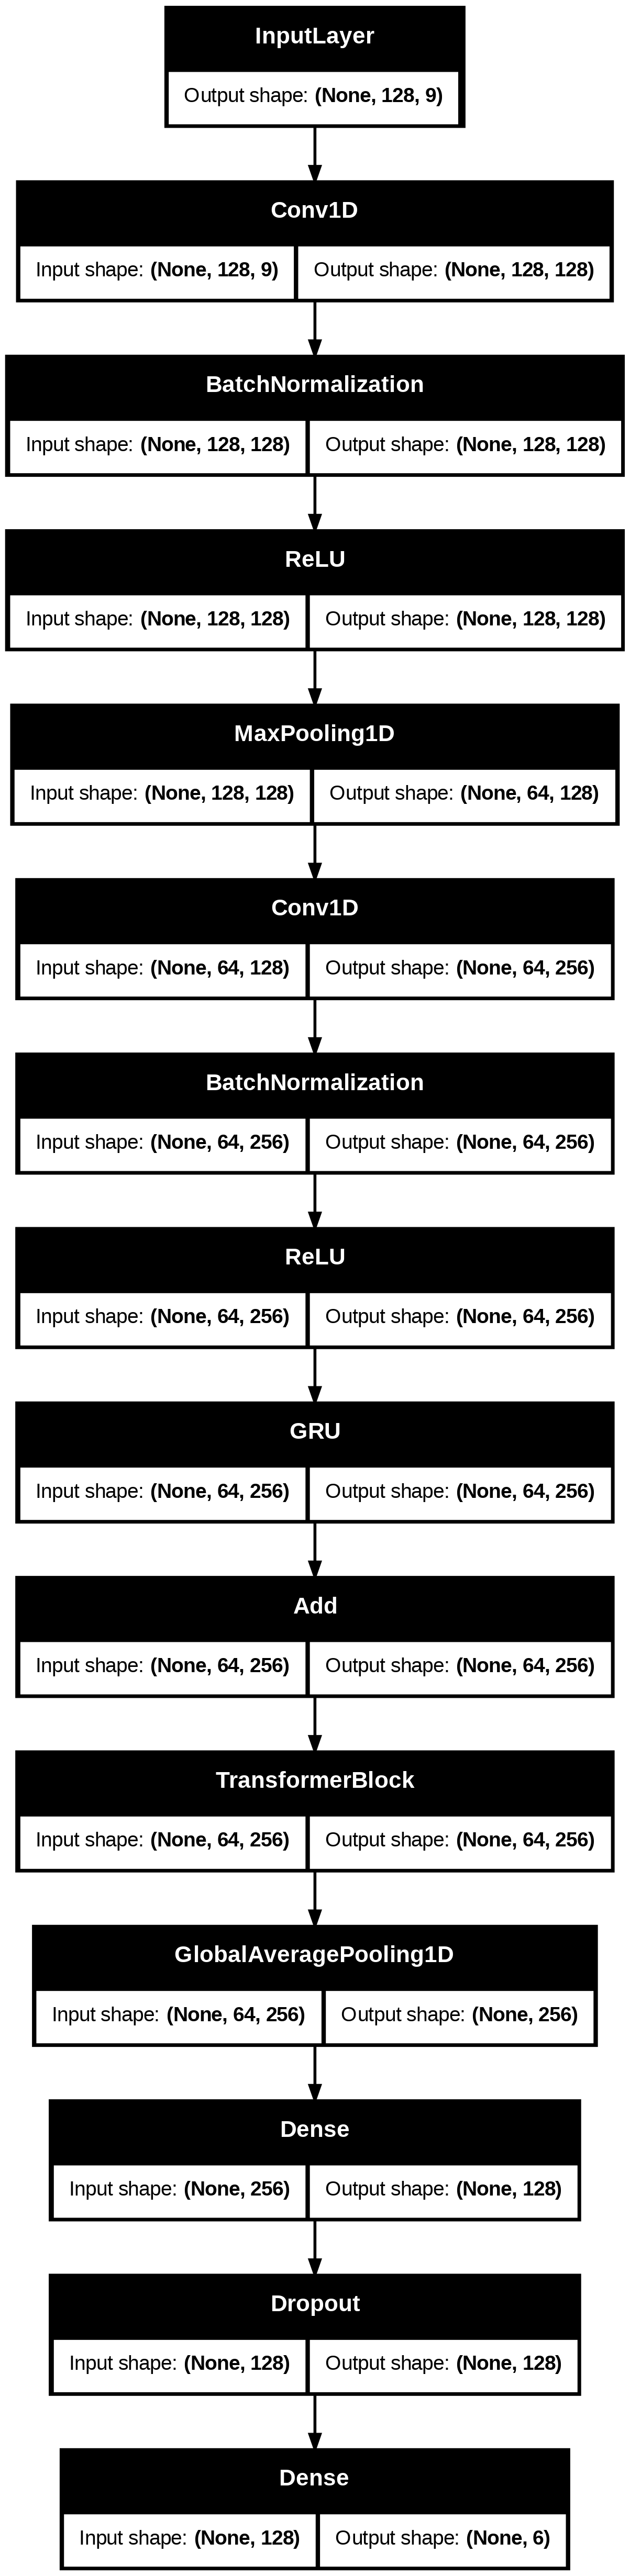

In [9]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [10]:
callbacks = [
            ModelCheckpoint(
                "UCI_HAR_CNN_GRU_Transformer_best.weights.h5",
                save_best_only=True,
                save_weights_only=True,
                monitor="val_sparse_categorical_accuracy",
                mode='max',
                verbose=1
            ),
            EarlyStopping(
                monitor="val_sparse_categorical_accuracy",
                patience=20,
                verbose=1,
                mode='max',
                restore_best_weights=True
            )
        ]

In [11]:
history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=64,
            validation_split=0.2,
            callbacks=callbacks,
            verbose=1
        )

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.7043 - sparse_categorical_accuracy: 0.7305
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.16927, saving model to UCI_HAR_CNN_GRU_Transformer_best.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - loss: 0.7008 - sparse_categorical_accuracy: 0.7318 - val_loss: 5.1220 - val_sparse_categorical_accuracy: 0.1693
Epoch 2/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1665 - sparse_categorical_accuracy: 0.9372
Epoch 2: val_sparse_categorical_accuracy improved from 0.16927 to 0.29436, saving model to UCI_HAR_CNN_GRU_Transformer_best.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.1659 - sparse_categorical_accuracy: 0.9373 - val_loss: 4.6368 - val_sparse_categorical_accuracy: 0.2944
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1313 - sparse_categorical_accuracy: 0.9529
Epoch 3: val_sparse_categorical_accuracy improved from 0.29436 to 0.68593, saving model to UCI_HAR_CNN_GRU_Tr

In [12]:
# 모델 평가
model = build_model(input_shape, num_classes)
model.load_weights("UCI_HAR_CNN_GRU_Transformer_best.weights.h5")

train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"Training accuracy: {train_acc * 100:.2f}%")
print(f"Training loss: {train_loss:.4f}")

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 64 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Training accuracy: 95.33%
Training loss: 0.1235
Test accuracy: 93.38%
Test loss: 0.2143


In [13]:
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.9744    0.9960    0.9850       496
           1     0.9889    0.9490    0.9686       471
           2     0.9745    1.0000    0.9871       420
           3     0.8117    0.8513    0.8310       491
           4     0.8651    0.8195    0.8417       532
           5     0.9981    1.0000    0.9991       537

    accuracy                         0.9338      2947
   macro avg     0.9354    0.9360    0.9354      2947
weighted avg     0.9342    0.9338    0.9337      2947



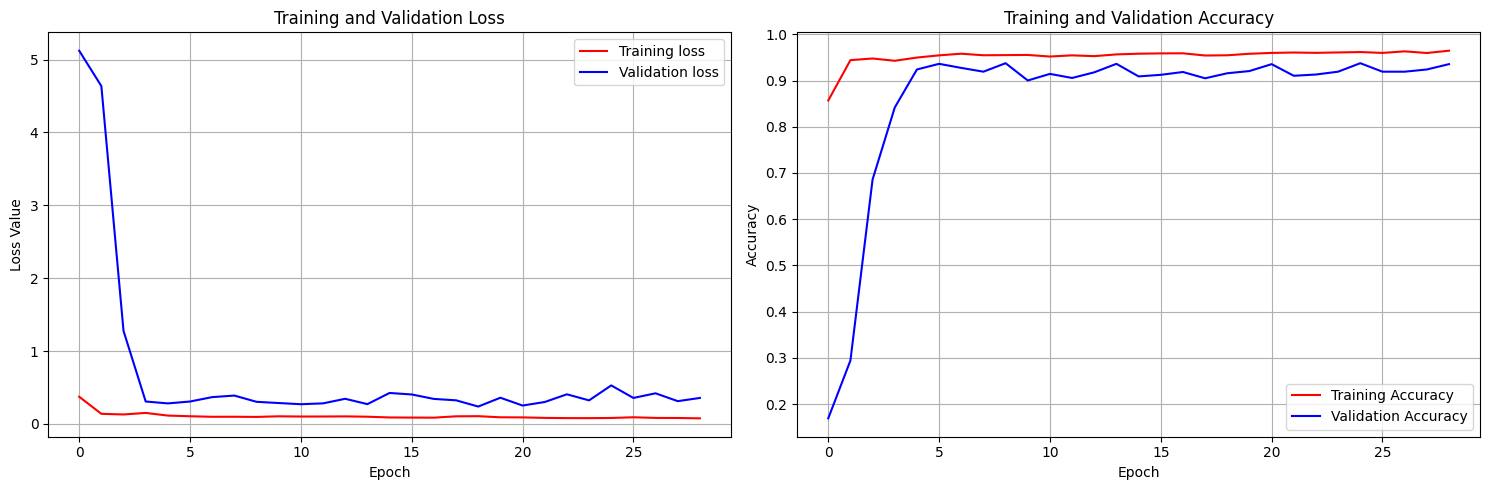

In [14]:
train_loss = history.history['loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

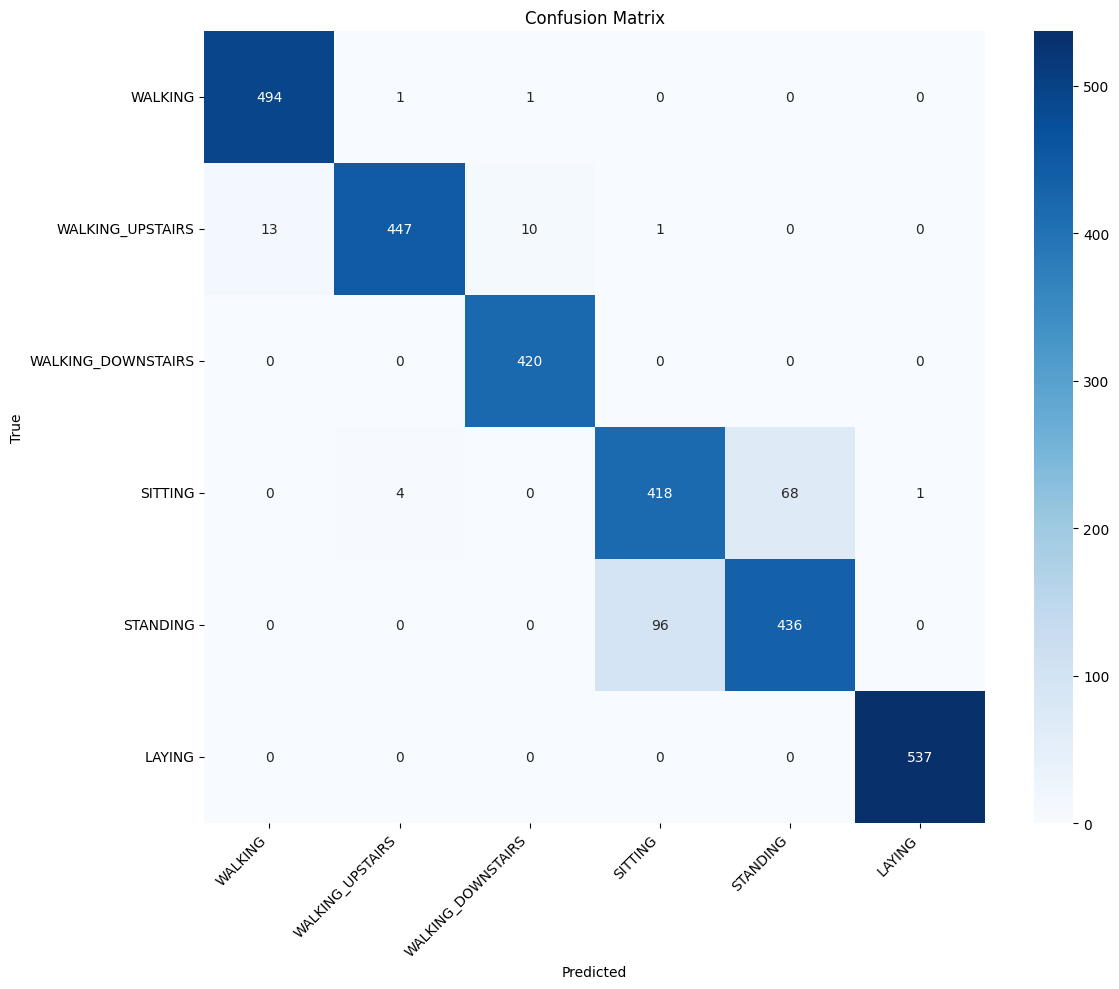

In [15]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

n_classes = len(np.unique(y_test))
if n_classes <= len(LABELS):
    plt.gca().set_xticklabels(LABELS[:n_classes], rotation=45, ha='right')
    plt.gca().set_yticklabels(LABELS[:n_classes], rotation=0)

plt.tight_layout()
plt.show()

## Model 2
- CNN 2, GRU 2, Transformer 1

In [17]:
input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, features)
num_classes = 6

def build_model(input_shape, num_classes=6):
    inputs = Input(shape=input_shape)

    # CNN 특징 추출 레이어
    x = Conv1D(128, 5, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPool1D(2)(x)

    x = Conv1D(256, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = GRU(256, return_sequences=True)(x)
    x = GRU(256, return_sequences=True)(x)

    pos_enc = positional_encoding(x.shape[1], x.shape[2])
    x += pos_enc

    x = TransformerBlock(embed_dim=256, num_heads=8, ff_dim=128)(x)

    x = GlobalAveragePooling1D()(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    return model

model = build_model(input_shape, num_classes)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 128, 128)       │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 64, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 64, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 64, 256)        │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 64, 256)        │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add_2 (Add)                     │ (None, 64, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ (None, 64, 256)        │       330,112 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,259,270 (4.80 MB)

 Trainable params: 1,258,502 (4.80 MB)

 Non-trainable params: 768 (3.00 KB)

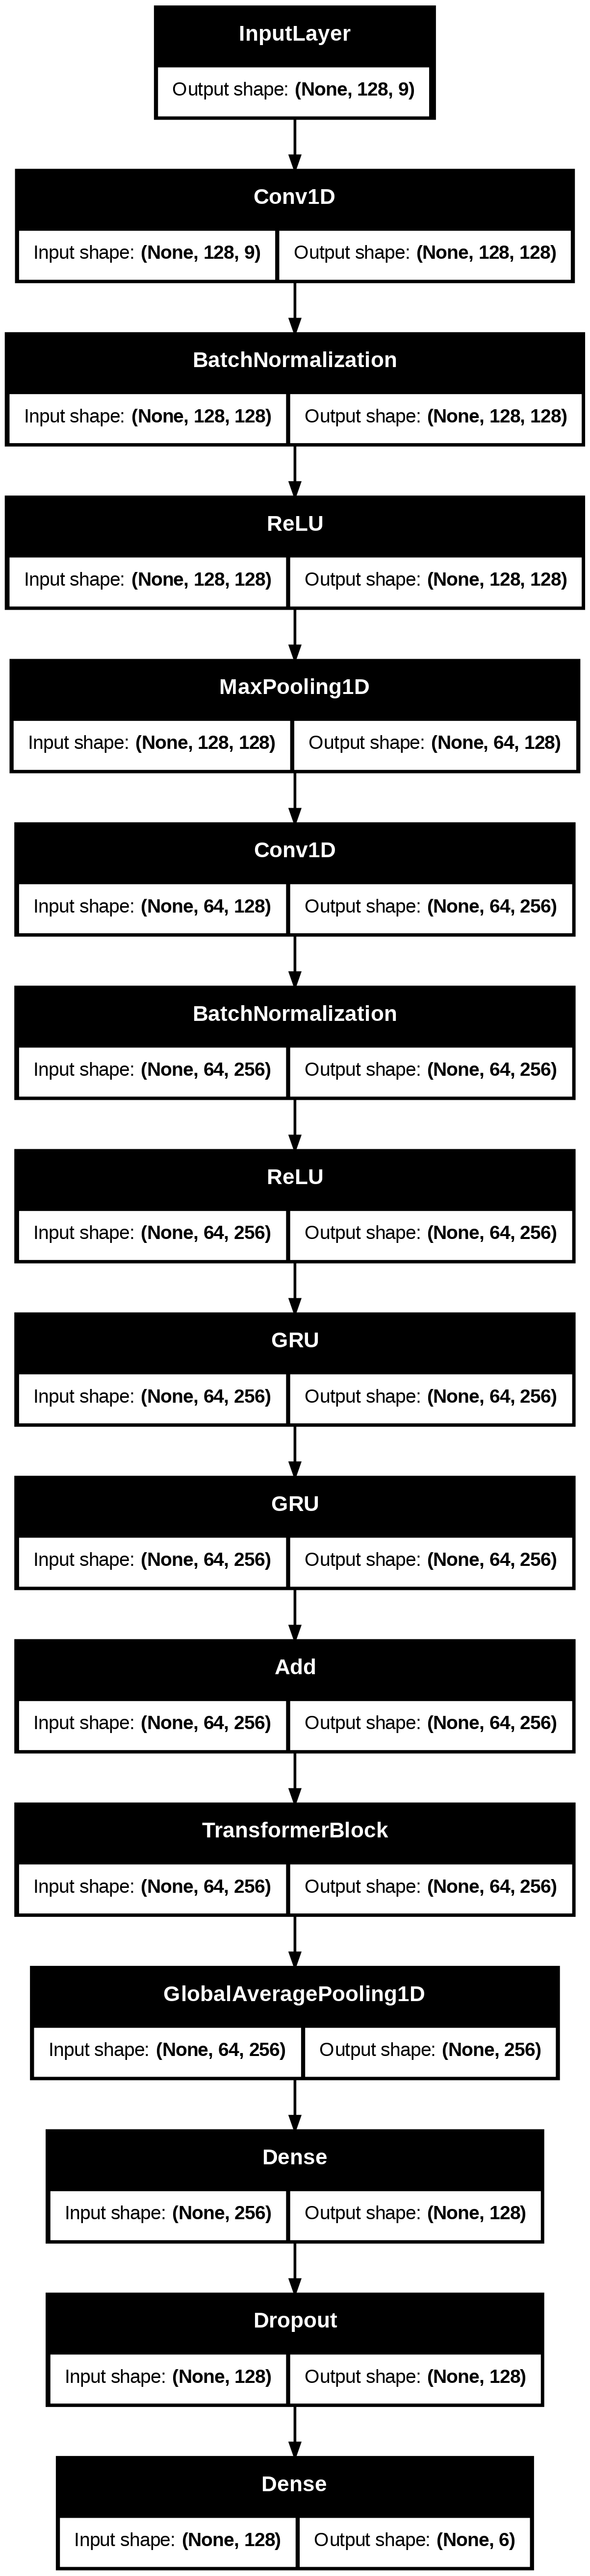

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [19]:
callbacks = [
            ModelCheckpoint(
                "UCI_HAR_CNN_GRU_Transformer_best2.weights.h5",
                save_best_only=True,
                save_weights_only=True,
                monitor="val_sparse_categorical_accuracy",
                mode='max',
                verbose=1
            ),
            EarlyStopping(
                monitor="val_sparse_categorical_accuracy",
                patience=20,
                verbose=1,
                mode='max',
                restore_best_weights=True
            )
        ]

In [20]:
history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=64,
            validation_split=0.2,
            callbacks=callbacks,
            verbose=1
        )

Epoch 1/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.7730 - sparse_categorical_accuracy: 0.6734
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.27532, saving model to UCI_HAR_CNN_GRU_Transformer_best2.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.7656 - sparse_categorical_accuracy: 0.6766 - val_loss: 5.5534 - val_sparse_categorical_accuracy: 0.2753
Epoch 2/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1519 - sparse_categorical_accuracy: 0.9392
Epoch 2: val_sparse_categorical_accuracy improved from 0.27532 to 0.30116, saving model to UCI_HAR_CNN_GRU_Transformer_best2.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.1518 - sparse_categorical_accuracy: 0.9392 - val_loss: 4.2963 - val_sparse_categorical_accuracy: 0.3012
Epoch 3/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1691 - sparse_categorical_accuracy: 0.9407
Epoch 3: val_sparse_categorical_accuracy improved from 0.30116 to 0.65398, saving model to UCI_HAR_CNN_GRU_T

In [21]:
# 모델 평가
model = build_model(input_shape, num_classes)
model.load_weights("UCI_HAR_CNN_GRU_Transformer_best2.weights.h5")

train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"Training accuracy: {train_acc * 100:.2f}%")
print(f"Training loss: {train_loss:.4f}")

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 70 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Training accuracy: 96.15%
Training loss: 0.1287
Test accuracy: 91.28%
Test loss: 0.5640


In [22]:
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.9979    0.9435    0.9699       496
           1     0.9888    0.9363    0.9618       471
           2     0.8872    0.9929    0.9371       420
           3     0.8460    0.7271    0.7820       491
           4     0.7886    0.8835    0.8333       532
           5     0.9871    1.0000    0.9935       537

    accuracy                         0.9128      2947
   macro avg     0.9159    0.9139    0.9130      2947
weighted avg     0.9156    0.9128    0.9123      2947



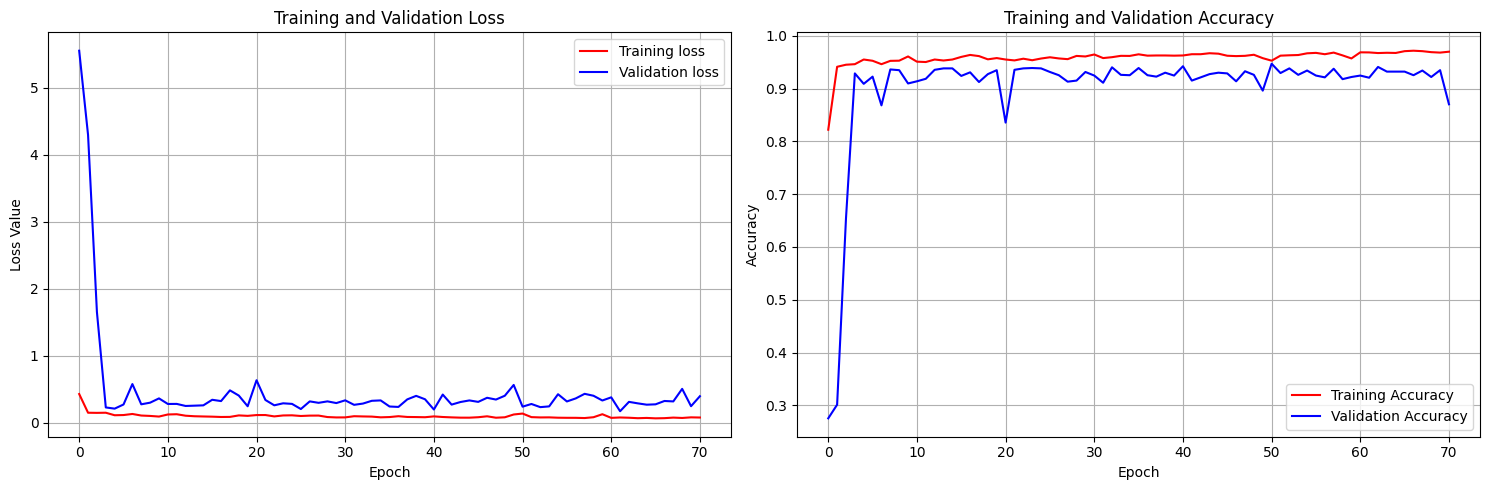

In [23]:
train_loss = history.history['loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

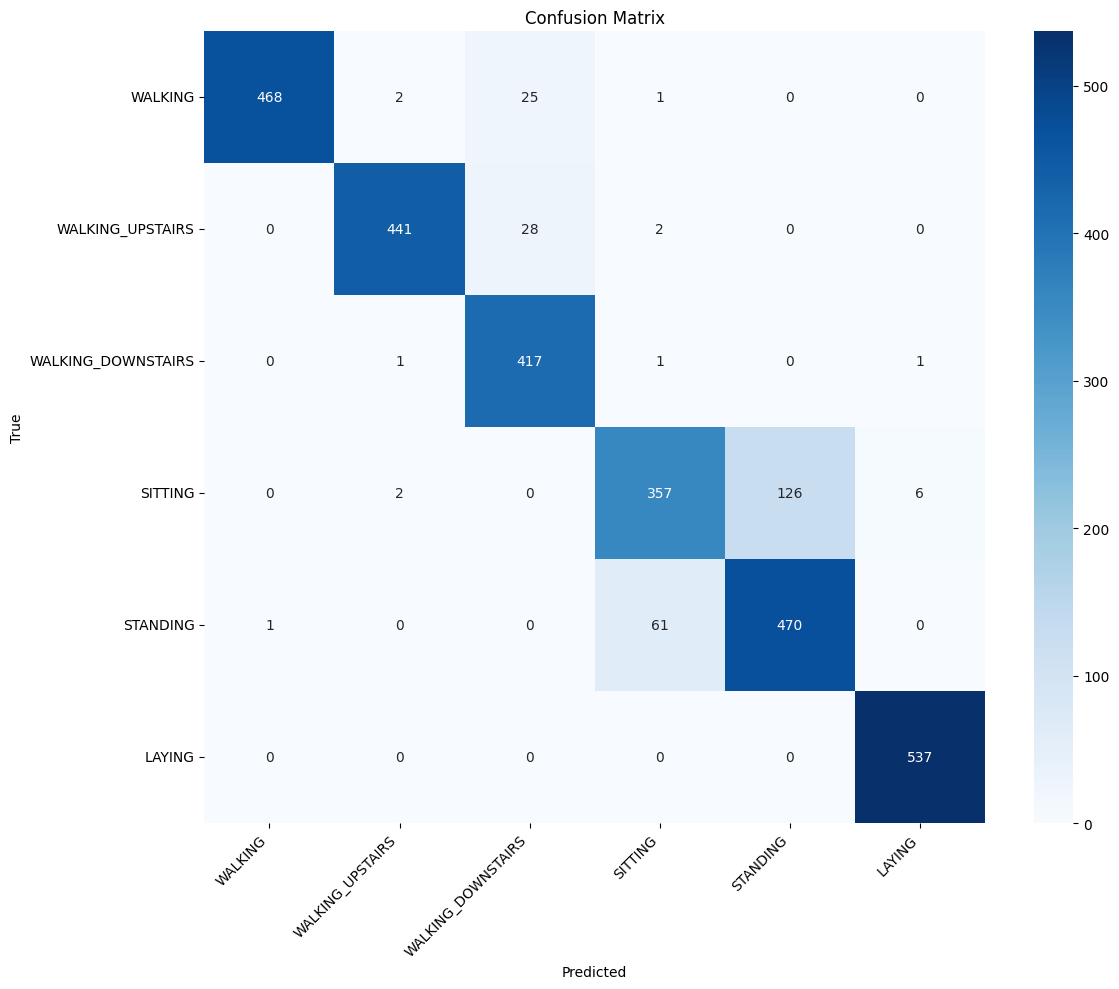

In [24]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

n_classes = len(np.unique(y_test))
if n_classes <= len(LABELS):
    plt.gca().set_xticklabels(LABELS[:n_classes], rotation=45, ha='right')
    plt.gca().set_yticklabels(LABELS[:n_classes], rotation=0)

plt.tight_layout()
plt.show()

## Model 3
- CNN 3, GRU 2, Transformer 1

In [25]:
input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, features)
num_classes = 6

def build_model(input_shape, num_classes=6):
    inputs = Input(shape=input_shape)

    # CNN 특징 추출 레이어
    x = Conv1D(128, 5, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv1D(128, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPool1D(2)(x)

    x = Conv1D(256, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = GRU(256, return_sequences=True)(x)
    x = GRU(256, return_sequences=True)(x)

    pos_enc = positional_encoding(x.shape[1], x.shape[2])
    x += pos_enc

    x = TransformerBlock(embed_dim=256, num_heads=8, ff_dim=128)(x)

    x = GlobalAveragePooling1D()(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    return model

model = build_model(input_shape, num_classes)
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 128, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 128, 128)       │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 128, 128)       │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 64, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 64, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_6 (GRU)                     │ (None, 64, 256)        │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 64, 256)        │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add_4 (Add)                     │ (None, 64, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_4             │ (None, 64, 256)        │       330,112 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,309,062 (4.99 MB)

 Trainable params: 1,308,038 (4.99 MB)

 Non-trainable params: 1,024 (4.00 KB)

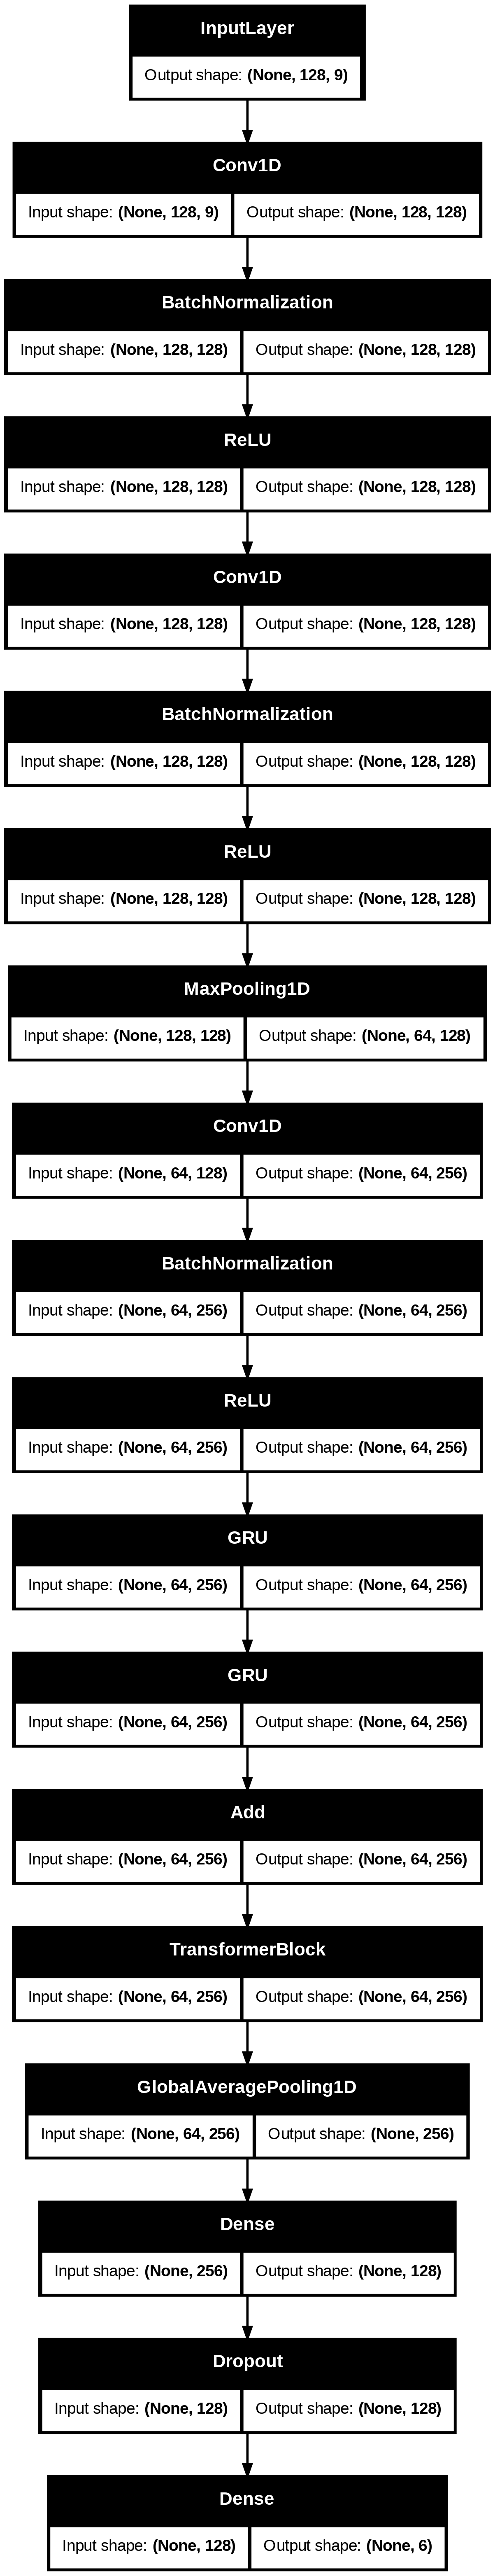

In [26]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [27]:
callbacks = [
            ModelCheckpoint(
                "UCI_HAR_CNN_GRU_Transformer_best3.weights.h5",
                save_best_only=True,
                save_weights_only=True,
                monitor="val_sparse_categorical_accuracy",
                mode='max',
                verbose=1
            ),
            EarlyStopping(
                monitor="val_sparse_categorical_accuracy",
                patience=20,
                verbose=1,
                mode='max',
                restore_best_weights=True
            )
        ]

In [28]:
history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=64,
            validation_split=0.2,
            callbacks=callbacks,
            verbose=1
        )

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.7392 - sparse_categorical_accuracy: 0.7053
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.18899, saving model to UCI_HAR_CNN_GRU_Transformer_best3.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - loss: 0.7356 - sparse_categorical_accuracy: 0.7068 - val_loss: 4.9147 - val_sparse_categorical_accuracy: 0.1890
Epoch 2/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1631 - sparse_categorical_accuracy: 0.9437
Epoch 2: val_sparse_categorical_accuracy improved from 0.18899 to 0.37865, saving model to UCI_HAR_CNN_GRU_Transformer_best3.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.1630 - sparse_categorical_accuracy: 0.9438 - val_loss: 2.9548 - val_sparse_categorical_accuracy: 0.3787
Epoch 3/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1382 - sparse_categorical_accuracy: 0.9416
Epoch 3: val_sparse_categorical_accuracy improved from 0.37865 to 0.85248, saving model to UCI_HAR_CNN_GRU_

In [29]:
# 모델 평가
model = build_model(input_shape, num_classes)
model.load_weights("UCI_HAR_CNN_GRU_Transformer_best3.weights.h5")

train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"Training accuracy: {train_acc * 100:.2f}%")
print(f"Training loss: {train_loss:.4f}")

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 78 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Training accuracy: 95.95%
Training loss: 0.1246
Test accuracy: 92.23%
Test loss: 0.4555


In [30]:
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.9816    0.9657    0.9736       496
           1     0.9530    0.9469    0.9499       471
           2     0.9093    0.9786    0.9427       420
           3     0.8631    0.7576    0.8069       491
           4     0.8327    0.8891    0.8600       532
           5     0.9944    1.0000    0.9972       537

    accuracy                         0.9223      2947
   macro avg     0.9224    0.9230    0.9217      2947
weighted avg     0.9224    0.9223    0.9214      2947



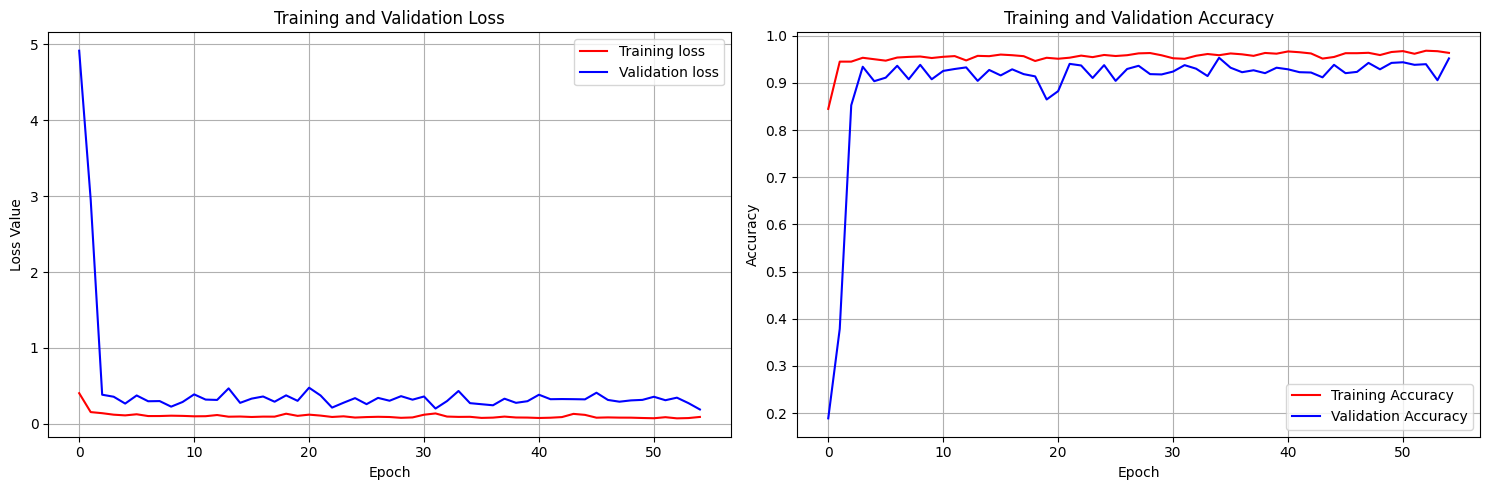

In [31]:
train_loss = history.history['loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

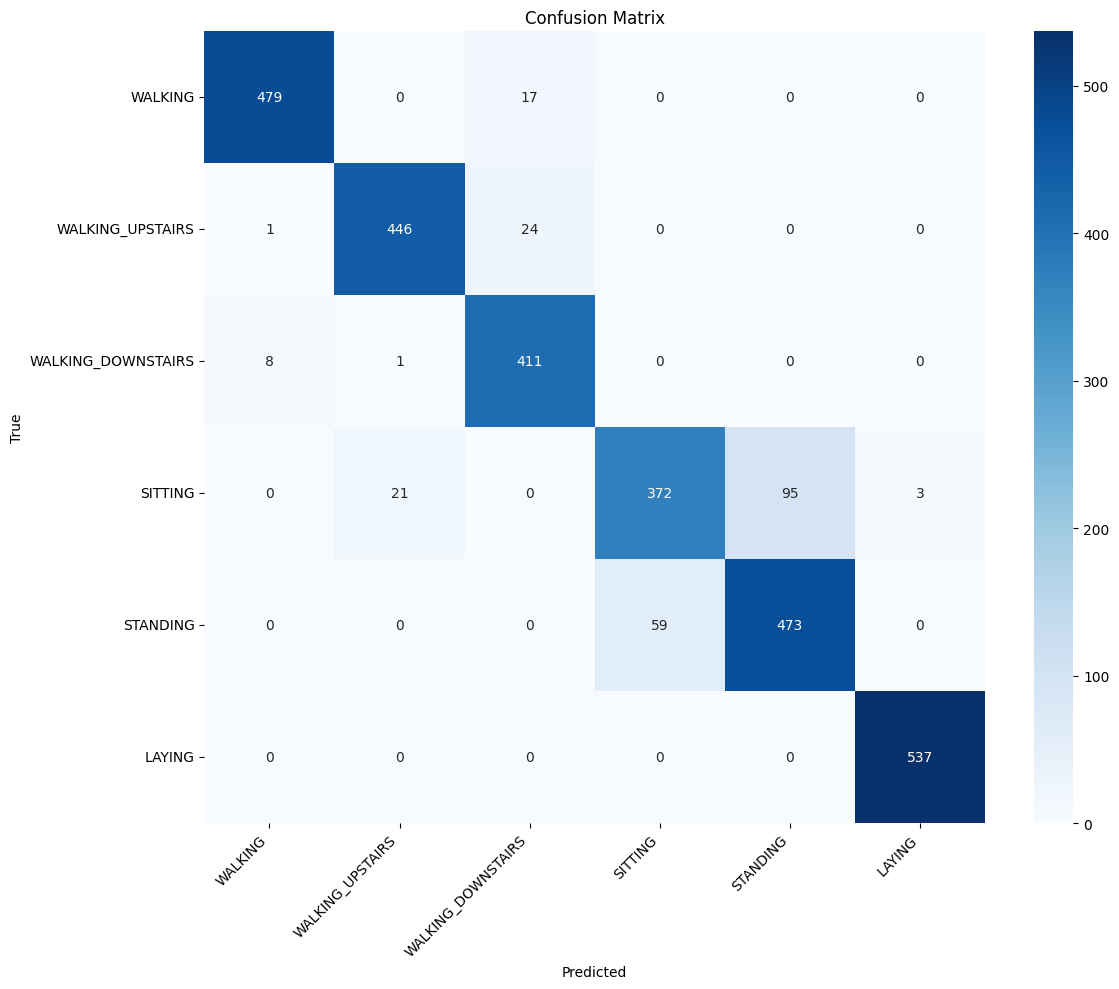

In [32]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

n_classes = len(np.unique(y_test))
if n_classes <= len(LABELS):
    plt.gca().set_xticklabels(LABELS[:n_classes], rotation=45, ha='right')
    plt.gca().set_yticklabels(LABELS[:n_classes], rotation=0)

plt.tight_layout()
plt.show()